In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.ndimage.filters import gaussian_filter as smooth

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 3

font = {'weight' : 'normal',
      'size'   : 17}

plt.rc('font', **font)

import fair
from fair.forward_original import fair_scm as fair_carbon
from fair.forward_multiple_GHG_plus_nat import fair_scm as fair_model
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions

fair.__version__

'1.0.1'

In [19]:
emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0

nat_emms_file = './fair/RCPs/RCP3PD_NAT_EMISSIONS.csv'
nat_emms_data = np.genfromtxt(nat_emms_file,skip_header=1,delimiter=',',names=True)

nat_M_emissions = nat_emms_data['CH4']
nat_N_emissions = nat_emms_data['N2O'] * 44.0 / 28.0

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

In [20]:
# FAIR STANDARD PARAMETERS
# DIFFERENCING METHOD WITH NATURAL EMISSIONS INCLUDED

#total
out_total = fair_model(emissions=emissions,M_emissions=M_emissions+nat_M_emissions,N_emissions=N_emissions+nat_N_emissions,
                            other_rf=other_rf,N_0=273.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus CO2
out_minus_co2 = fair_model(M_emissions=M_emissions+nat_M_emissions,N_emissions=N_emissions+nat_N_emissions,
                            other_rf=other_rf,N_0=273.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus anthro CH4
out_minus_ch4 = fair_model(emissions=emissions,M_emissions=nat_M_emissions,N_emissions=N_emissions+nat_N_emissions,
                            other_rf=other_rf,N_0=273.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus anthro N2O
out_minus_n2o = fair_model(emissions=emissions,M_emissions=M_emissions+nat_M_emissions,N_emissions=nat_N_emissions,
                            other_rf=other_rf,N_0=273.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus other
out_minus_other = fair_model(emissions=emissions,M_emissions=M_emissions+nat_M_emissions,N_emissions=N_emissions+nat_N_emissions,
                            N_0=273.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#anthro total from RCP3 RF datafile
C_anthro_0, T_anthro_0, RF_anthro_0 = fair_carbon(other_rf=forc_data['TOTAL_ANTHRO_RF'])

# Smoothing
anthro_0_RF = smooth(RF_anthro_0,5)
total_RF = smooth(out_total['forcing']['total'],5)
total_minus_co2_RF = smooth(out_minus_co2['forcing']['total'],5)
total_minus_ch4_RF = smooth(out_minus_ch4['forcing']['total'],5)
total_minus_n2o_RF = smooth(out_minus_n2o['forcing']['total'],5)
total_minus_other_RF = smooth(out_minus_other['forcing']['total'],5)

# Concentrations
anthro_0_conc = rf_to_conc(anthro_0_RF)
total_conc = rf_to_conc(total_RF)
total_minus_co2_conc = rf_to_conc(total_minus_co2_RF)
total_minus_ch4_conc = rf_to_conc(total_minus_ch4_RF)
total_minus_n2o_conc = rf_to_conc(total_minus_n2o_RF)
total_minus_other_conc = rf_to_conc(total_minus_other_RF)

# annual emissions
anthro_0_co2_fe_ems = conc_to_emissions(anthro_0_conc,T_anthro_0,year_smoothing=0)* 44./12.
total_co2_fe_ems = conc_to_emissions(total_conc,out_total['temperature'],year_smoothing=0)* 44./12.
total_minus_co2_co2_fe_ems = conc_to_emissions(total_minus_co2_conc,out_minus_co2['temperature'],year_smoothing=0)* 44./12.
total_minus_ch4_co2_fe_ems = conc_to_emissions(total_minus_ch4_conc,out_minus_ch4['temperature'],year_smoothing=0)* 44./12.
total_minus_n2o_co2_fe_ems = conc_to_emissions(total_minus_n2o_conc,out_minus_n2o['temperature'],year_smoothing=0)* 44./12.
total_minus_other_co2_fe_ems = conc_to_emissions(total_minus_other_conc,out_minus_other['temperature'],year_smoothing=0)* 44./12.

#differencing emissions...
co2_co2_fe_ems = total_co2_fe_ems - total_minus_co2_co2_fe_ems
ch4_co2_fe_ems = total_co2_fe_ems - total_minus_ch4_co2_fe_ems
n2o_co2_fe_ems = total_co2_fe_ems - total_minus_n2o_co2_fe_ems
other_co2_fe_ems = total_co2_fe_ems - total_minus_other_co2_fe_ems

# # # MYLES METHOD
from fair.fair_inverse_model import annual_emissions_calc as myles_calc
anthro_0_co2_fe_ems1 = myles_calc(anthro_0_conc,T_anthro_0)* 44./12.
total_co2_fe_ems1 = myles_calc(total_conc,out_total['temperature'])* 44./12.
total_minus_co2_co2_fe_ems1 = myles_calc(total_minus_co2_conc,out_minus_co2['temperature'])* 44./12.
total_minus_ch4_co2_fe_ems1 = myles_calc(total_minus_ch4_conc,out_minus_ch4['temperature'])* 44./12.
total_minus_n2o_co2_fe_ems1 = myles_calc(total_minus_n2o_conc,out_minus_n2o['temperature'])* 44./12.
total_minus_other_co2_fe_ems1 = myles_calc(total_minus_other_conc,out_minus_other['temperature'])* 44./12.
# # # differencing emissions...myles
co2_co2_fe_ems1 = total_co2_fe_ems1 - total_minus_co2_co2_fe_ems1
ch4_co2_fe_ems1 = total_co2_fe_ems1 - total_minus_ch4_co2_fe_ems1
n2o_co2_fe_ems1 = total_co2_fe_ems1 - total_minus_n2o_co2_fe_ems1
other_co2_fe_ems1 = total_co2_fe_ems1 - total_minus_other_co2_fe_ems1

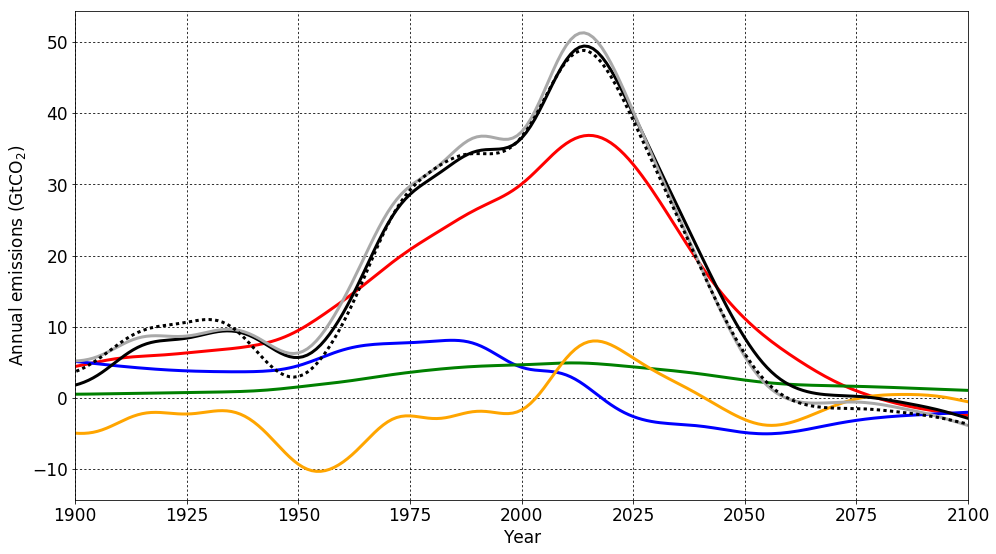

In [21]:
time = np.arange(1765,2501)

total_sum_ems = co2_co2_fe_ems + ch4_co2_fe_ems + n2o_co2_fe_ems + other_co2_fe_ems

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(time, co2_co2_fe_ems, color = 'red')
ax1.plot(time, ch4_co2_fe_ems, color = 'blue')
ax1.plot(time, n2o_co2_fe_ems, color = 'green')
ax1.plot(time, other_co2_fe_ems, color = 'orange')
ax1.plot(time, total_co2_fe_ems, color = 'black')
ax1.plot(time, total_sum_ems, color = 'darkgrey')
ax1.plot(time, anthro_0_co2_fe_ems, ':', color = 'black')
ax1.set_xlim(1900,2100)
ax1.grid(True, linestyle = ':', color = 'black')
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual emissions (GtCO$_2$)')

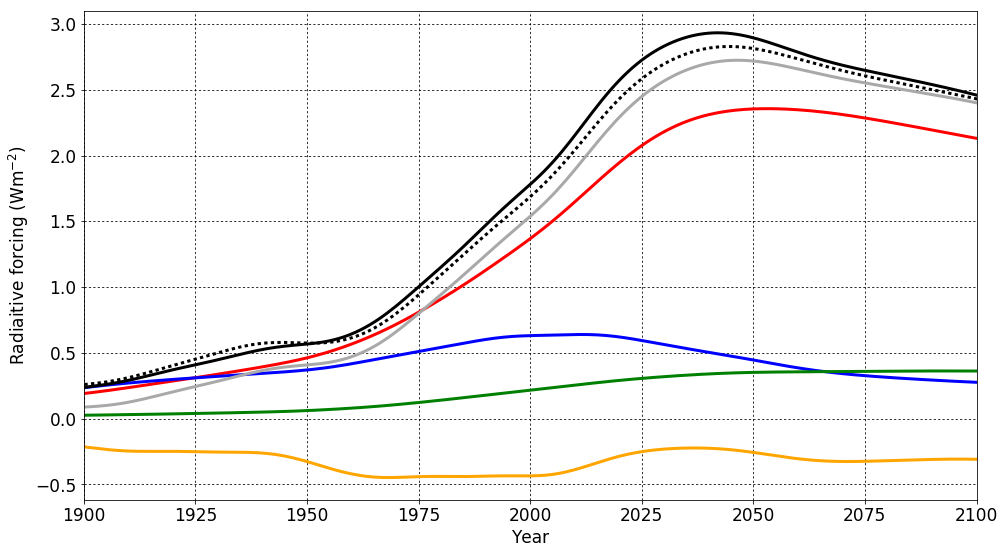

In [22]:
C_anthro_0, T_anthro_0, RF_anthro_0 = fair_carbon(emissions = anthro_0_co2_fe_ems * 12./44.)
C_total, T_total, RF_total = fair_carbon(emissions = total_co2_fe_ems * 12./44.)
C_co2, T_co2, RF_co2 = fair_carbon(emissions = co2_co2_fe_ems * 12./44.)
C_ch4, T_ch4, RF_ch4 = fair_carbon(emissions = ch4_co2_fe_ems * 12./44.)
C_n2o, T_n2o, RF_n2o = fair_carbon(emissions = n2o_co2_fe_ems * 12./44.)
C_other, T_other, RF_other = fair_carbon(emissions = other_co2_fe_ems * 12./44.)

RF_sum = RF_co2 + RF_ch4 + RF_n2o + RF_other

#MYLES METHOD
C_anthro_01, T_anthro_01, RF_anthro_01 = fair_carbon(emissions = anthro_0_co2_fe_ems1 * 12./44.)
C_total1, T_total1, RF_total1 = fair_carbon(emissions = total_co2_fe_ems1 * 12./44.)
C_co21, T_co21, RF_co21 = fair_carbon(emissions = co2_co2_fe_ems1 * 12./44.)
C_ch41, T_ch41, RF_ch41 = fair_carbon(emissions = ch4_co2_fe_ems1 * 12./44.)
C_n2o1, T_n2o1, RF_n2o1 = fair_carbon(emissions = n2o_co2_fe_ems1 * 12./44.)
C_other1, T_other1, RF_other1 = fair_carbon(emissions = other_co2_fe_ems1 * 12./44.)
RF_sum1 = RF_co21 + RF_ch41 + RF_n2o1 + RF_other1


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(time, RF_co2, color = 'red')
ax2.plot(time, RF_ch4, color = 'blue')
ax2.plot(time, RF_n2o, color = 'green')
ax2.plot(time, RF_other, color = 'orange')
ax2.plot(time, RF_anthro_0, ':', color = 'black')
ax2.plot(time, RF_total, color = 'darkgrey')
ax2.plot(time, RF_sum, color = 'black')
ax2.set_xlim(1900,2100)
ax2.grid(True, linestyle = ':', color = 'black')
ax2.set_xlabel('Year')
ax2.set_ylabel('Radiaitive forcing (Wm$^{-2}$)')

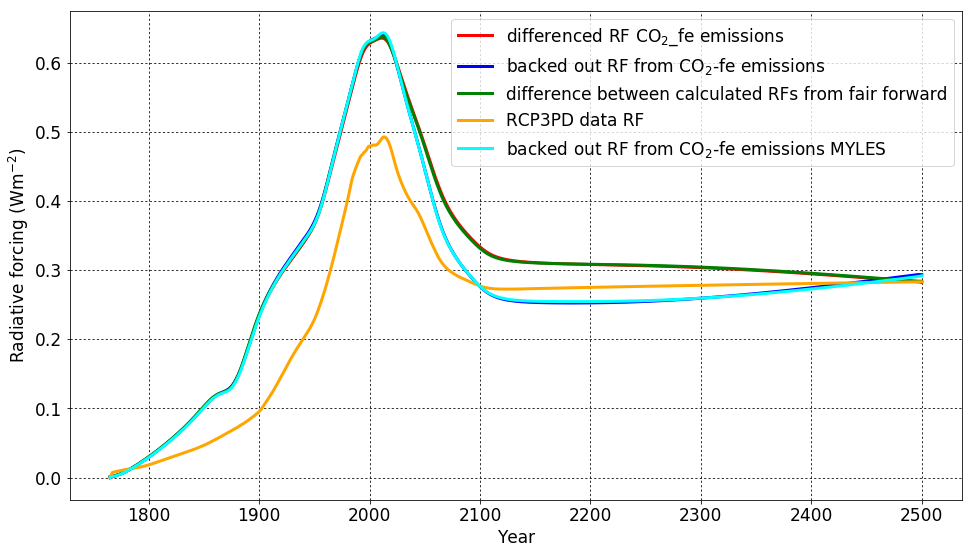

In [23]:
test_conc = rf_to_conc(total_RF - total_minus_ch4_RF)
T_diff = out_total['temperature'] - out_minus_ch4['temperature']
test_ems = conc_to_emissions(test_conc,T_diff,year_smoothing=0)* 44./12.
C_test, T_test, RF_test = fair_carbon(emissions = test_ems * 12./44.)

plt.plot(time, RF_test, color = 'red', label = 'differenced RF CO$_2$_fe emissions')
plt.plot(time, RF_ch4, color = 'blue', label = 'backed out RF from CO$_2$-fe emissions')
plt.plot(time, total_RF - total_minus_ch4_RF, color = 'green', label = 'difference between calculated RFs from fair forward')
plt.plot(time, forc_data['CH4_RF'], color = 'orange', label = 'RCP3PD data RF')

plt.plot(time, RF_ch41, color = 'cyan', label = 'backed out RF from CO$_2$-fe emissions MYLES')

plt.grid(True, linestyle = ':', color = 'black')
plt.legend(loc = 'best')
plt.xlabel('Year')
plt.ylabel('Radiative forcing (Wm$^{-2}$)')

(-12, 40)

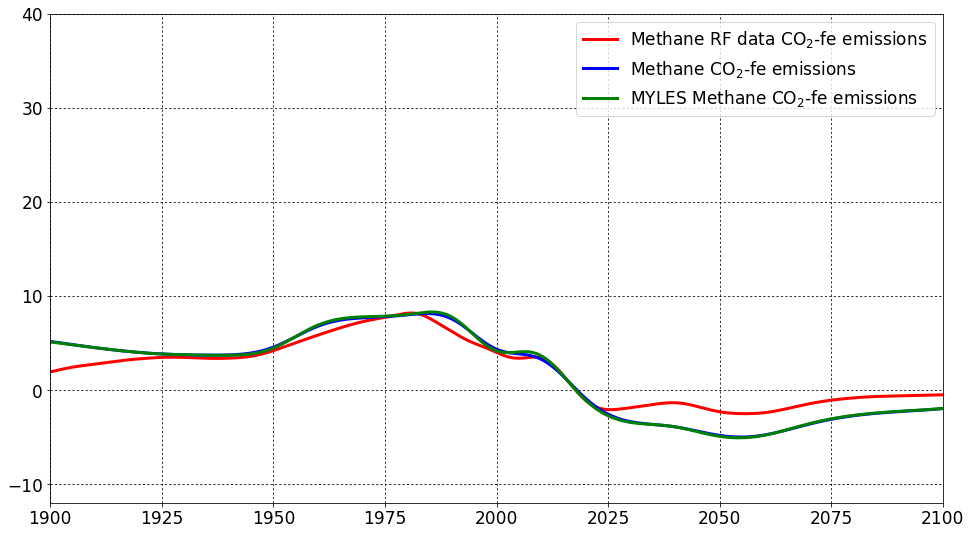

In [24]:
C_ch4_RF_data, T_ch4_RF_data, RF_ch4_RF_data = fair_carbon(other_rf = forc_data['CH4_RF'])
ch4_RF_conc = rf_to_conc(RF_ch4_RF_data)
ch4_RF_co2_fe_ems = conc_to_emissions(ch4_RF_conc,T_ch4_RF_data,year_smoothing=0)* 44./12.

plt.plot(time, ch4_RF_co2_fe_ems, color = 'red', label = 'Methane RF data CO$_2$-fe emissions')
plt.plot(time, ch4_co2_fe_ems, color = 'blue', label = 'Methane CO$_2$-fe emissions')
plt.plot(time, ch4_co2_fe_ems1, color = 'green', label = 'MYLES Methane CO$_2$-fe emissions')
plt.xlim(1900,2100)
plt.grid(True, linestyle = ':', color = 'black')
plt.legend(loc = 'best')
plt.ylim(-12,40)

PROBLEM: When we find the radiative forcings through all the different means we find that the RCP3PD datafile RF doesn't match the RFs we calculate, either by differencing at the RF stage (after nicks code), or at the end (at co2_fe step). 
This is because the natural emissions code is allowed to decay the entire concentration pile. This is a problem and means when we look at the concentration over time we find a dip and this is inconsistent with observations (roughly constant CH4 concentrations through historical period). We CANNOT reconcile what we are finding with the RCP3PD RF datafile. 

SOLUTION: Nick will try and write a new forward code which calculates the natural and anthropogenic contributions with 2 different lifetimes. This should allow us to find natural emissions which give a baseline of constant concentrations of methane etc through time, and then the anthro emissions on top emulate the RF profile the RCP3PD datafile gives. (RCP3PD RF datafile is anthro only contribution). 

In the mean time I produce plots using the old code, to try and get the plotting equipment ready. If nick produces new stuff which is better it is simply a matter of plugging it in to my plotter...